In [ ]:
!pip uninstall -y scikit-learn
!pip uninstall -y sklearn

!pip install scikit-learn==1.3.2
!pip install -U numpy==1.26.4 scipy==1.10.1
!pip install -U scikit-learn==1.3.2
!pip install -U opencv-python==4.8.1.78 opencv-contrib-python==4.8.1.78
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install -U tensorflow-addons==0.21.0

import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

import cv2
import time
import json
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.activations import swish
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal

from tensorflow.keras.layers import (
    Layer, 
    Input, 
    Conv2D, 
    BatchNormalization, 
    Lambda, 
    Concatenate,
    SeparableConv2D, 
    MaxPooling2D, 
    UpSampling2D, 
    Conv2DTranspose,
    SpatialDropout2D, 
    ReLU, 
    GlobalAveragePooling2D, 
    Add,
    GlobalMaxPooling2D, 
    Dense, 
    Reshape, 
    Multiply, 
    Activation
)

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 101.6 MB/s eta 0:00:0000:01:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.3.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 58.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that ar

2025-12-14 19:13:25.272112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765739605.470560      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765739605.526717      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
working_dir = '/kaggle/working'
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)
            print(f"❌ xóa thành công {item_path}")
    except Exception as e:
        print(f"Lỗi khi xóa {item_path}: {e}")

❌ xóa thành công /kaggle/working/.virtual_documents


In [3]:
def load_isic_dataset(image_path, mask_path, binary_path, csv_file, img_size=(256, 256)):
    image_files = sorted(glob(os.path.join(image_path, "ISIC_*.jpg")))
    images = []
    masks = []
    binary_masks = {}
    image_ids = []
    labels = []


    csv_data = pd.read_csv(csv_file)
    mel_label = csv_data['melanoma'].astype("int64")

    print("Đang đọc và xử lý dữ liệu...")
    for index, img_path in enumerate(tqdm(image_files)):
        img_id = os.path.basename(img_path).split('.')[0]
        mask_file = os.path.join(mask_path, f"{img_id}_segmentation.png")
        binary_file = os.path.join(binary_path, f"{img_id}_features.json")

        if not os.path.exists(mask_file):
            print(f"Không tìm thấy mask cho ảnh mặt nạ {img_id}_segmentation.png")
            continue
        if not os.path.exists(binary_file):
            print(f"Không tìm thấy mask nhị phân cho ảnh {img_id}_features.json")
            continue

        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, img_size)
            mask = cv2.resize(mask, img_size)

            img = img / 255.0
            mask = mask / 255.0

            with open(binary_file, 'r') as f:
                binary_masks[img_id] = json.load(f)

            label = mel_label[index]

            images.append(img)
            masks.append(mask)
            image_ids.append(img_id)
            labels.append(label.astype("long"))

        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {img_id}: {str(e)}")
            continue

    images = np.array(images)
    masks = np.array(masks)[..., np.newaxis]  
    labels = np.array(labels)

    print(f"\nĐã đọc thành công {len(images)} ảnh")
    print(f"Shape của images: {images.shape}")
    print(f"Shape của masks: {masks.shape}")
    print(f"Shape của labels: {labels.shape}")

    return images, masks, binary_masks, image_ids, labels

In [4]:
train_images, train_masks, train_binarys, train_image_ids, train_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2750/Train_Data',
    mask_path='/kaggle/input/isic-2750/Train_GroundTruth_1',
    binary_path='/kaggle/input/isic-2750/Train_GroundTruth_2',
    csv_file="/kaggle/input/isic-2750/Train_GroundTruth_3.csv",
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 1925/1925 [07:30<00:00,  4.28it/s]



Đã đọc thành công 1925 ảnh
Shape của images: (1925, 256, 256, 3)
Shape của masks: (1925, 256, 256, 1)
Shape của labels: (1925,)


In [5]:
test_images, test_masks, test_binarys, test_image_ids, test_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2750/Test_Data',
    mask_path='/kaggle/input/isic-2750/Test_GroundTruth_1',
    binary_path='/kaggle/input/isic-2750/Test_GroundTruth_2',
    csv_file='/kaggle/input/isic-2750/Test_GroundTruth_3.csv',
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 825/825 [02:53<00:00,  4.75it/s]



Đã đọc thành công 825 ảnh
Shape của images: (825, 256, 256, 3)
Shape của masks: (825, 256, 256, 1)
Shape của labels: (825,)


In [6]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou

In [7]:
def compute_metric(y_true, y_pred, metric='dice_coefficient', smooth=1e-6, is_numpy=False):
    y_true_f = y_true.flatten() if is_numpy else K.flatten(y_true)
    y_pred_f = y_pred.flatten() if is_numpy else K.flatten(y_pred)
    intersection = np.sum(y_true_f * y_pred_f) if is_numpy else K.sum(y_true_f * y_pred_f)

    if 'dice' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        score = (2. * intersection + smooth) / (sum_fn(y_true_f) + sum_fn(y_pred_f) + smooth)
    elif 'jaccard' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        union = sum_fn(y_true_f) + sum_fn(y_pred_f) - intersection
        score = (intersection + smooth) / (union + smooth)
    else:
        raise ValueError(f"Unsupported metric: {metric}")

    return score if 'coefficient' in metric else 1 - score

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth)

def jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth)

def jaccard_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_loss', smooth)

def np_accuracy(y_true, y_pred):
    return np.mean(y_true.flatten() == y_pred.flatten())

def np_dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth, is_numpy=True)

def np_jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth, is_numpy=True)

def np_dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth, is_numpy=True)

In [8]:
def cbam_module(input_features, reduction_ratio=8):

    filters = input_features.shape[-1]
    
    avg_pool = GlobalAveragePooling2D()(input_features)
    max_pool = GlobalMaxPooling2D()(input_features)
    
    shared_dense_1 = Dense(filters // reduction_ratio, 
                           activation='relu', 
                           kernel_initializer='he_normal', 
                           use_bias=True)
    
    shared_dense_2 = Dense(filters, 
                           use_bias=True)
    
    avg_out = shared_dense_2(shared_dense_1(avg_pool))
    max_out = shared_dense_2(shared_dense_1(max_pool))
    
    channel_sum = Add()([avg_out, max_out])
    channel_attention = Activation('sigmoid')(channel_sum)
    channel_attention = Reshape((1, 1, filters))(channel_attention)
    channel_refined = Multiply()([input_features, channel_attention])
    
   
    avg_spatial = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True), 
                         output_shape=lambda s: (s[0], s[1], s[2], 1))(channel_refined)
    max_spatial = Lambda(lambda x: K.max(x, axis=-1, keepdims=True), 
                         output_shape=lambda s: (s[0], s[1], s[2], 1))(channel_refined)
    
    spatial_concat = Concatenate(axis=-1)([avg_spatial, max_spatial])
    
    spatial_attention = Conv2D(1, 
                               (7, 7), 
                               padding='same', 
                               activation='sigmoid', 
                               use_bias=False)(spatial_concat)
    
    refined_features = Multiply()([channel_refined, spatial_attention])
    
    
    return refined_features

In [9]:
def simam(x, lambda_val=1e-4):  
    shape = tf.shape(x)
    H, W = shape[1], shape[2]
    n = tf.cast(H * W - 1, x.dtype)
    
    mu = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
    d = tf.square(x - mu)
    var = tf.reduce_sum(d, axis=[1, 2], keepdims=True) / n
    e_t = d / (4 * (var + lambda_val)) + 0.5
    
    return x * tf.nn.sigmoid(e_t)

def aspp_module(input_tensor, output_filters=1024, rates=[1, 6, 12, 18]):
    num_branches = len(rates)
    branch_filters = output_filters // num_branches

    branches = []
    for rate in rates:
        branch = SeparableConv2D(branch_filters, (3, 3), padding='same', dilation_rate=rate, use_bias=False,
                                  depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(input_tensor)
        branch = BatchNormalization()(branch)
        branch = ReLU()(branch)
        branches.append(branch)

    concatenated = Concatenate()(branches)
    attended = Lambda(simam)(concatenated)


    final_conv = SeparableConv2D(output_filters, (1, 1), padding='same', use_bias=False,
                                  depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(attended)
    final_conv = BatchNormalization()(final_conv)
    final_conv = ReLU()(final_conv)
    final_conv = SpatialDropout2D(0.2)(final_conv)
    return final_conv

In [10]:
def CustomSegUNet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    c1 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(inputs)
    c1 = BatchNormalization()(c1); c1 = ReLU()(c1)
    c1 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c1)
    c1 = BatchNormalization()(c1); c1 = ReLU()(c1)
    c1 = SpatialDropout2D(0.1)(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p1)
    c2 = BatchNormalization()(c2); c2 = ReLU()(c2)
    c2 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c2)
    c2 = BatchNormalization()(c2); c2 = ReLU()(c2)
    c2 = SpatialDropout2D(0.1)(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p2)
    c3 = BatchNormalization()(c3); c3 = ReLU()(c3)
    c3 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c3)
    c3 = BatchNormalization()(c3); c3 = ReLU()(c3)
    c3 = SpatialDropout2D(0.1)(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p3)
    c4 = BatchNormalization()(c4); c4 = ReLU()(c4)
    c4 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c4)
    c4 = BatchNormalization()(c4); c4 = ReLU()(c4)
    c4 = SpatialDropout2D(0.1)(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p4)
    c5 = BatchNormalization()(c5); c5 = ReLU()(c5)
    c5 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c5)
    c5 = BatchNormalization()(c5); c5 = ReLU()(c5)
    c5 = SpatialDropout2D(0.1)(c5)
    p5 = MaxPooling2D((2, 2))(c5)

    c6 = aspp_module(p5, output_filters=1024, rates=[1, 6, 12, 18])

    u7 = Conv2DTranspose(512, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c6)
    u7 = Concatenate()([u7, c5])
    c7 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u7)
    c7 = BatchNormalization()(c7); c7 = ReLU()(c7)
    c7 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c7)
    c7 = BatchNormalization()(c7); c7 = ReLU()(c7)
    c7 = cbam_module(c7)

    u8 = Conv2DTranspose(256, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c7)
    u8 = Concatenate()([u8, c4])
    c8 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u8)
    c8 = BatchNormalization()(c8); c8 = ReLU()(c8)
    c8 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c8)
    c8 = BatchNormalization()(c8); c8 = ReLU()(c8)
    c8 = cbam_module(c8)

    u9 = Conv2DTranspose(256, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c8)
    u9 = Concatenate()([u9, c3])
    c9 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u9)
    c9 = BatchNormalization()(c9); c9 = ReLU()(c9)
    c9 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c9)
    c9 = BatchNormalization()(c9); c9 = ReLU()(c9)
    c9 = cbam_module(c9)

    u10 = Conv2DTranspose(128, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c9)
    u10 = Concatenate()([u10, c2])
    c10 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u10)
    c10 = BatchNormalization()(c10); c10 = ReLU()(c10)
    c10 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c10)
    c10 = BatchNormalization()(c10); c10 = ReLU()(c10)
    c10 = cbam_module(c10)

    u11 = Conv2DTranspose(64, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c10)
    u11 = Concatenate()([u11, c1])
    c11 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u11)
    c11 = BatchNormalization()(c11); c11 = ReLU()(c11)
    c11 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c11)
    c11 = BatchNormalization()(c11); c11 = ReLU()(c11)
    c11 = cbam_module(c11)

 
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c11)

    return Model(inputs=inputs, outputs=outputs)

if __name__ == "__main__":
    model = CustomSegUNet()
    model.summary()

I0000 00:00:1765740290.404731      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 256, 256,  │        137 │ input_layer[0][0] │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 256, 256,  │      4,736 │ re_lu[0][0]       │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 256, 256,  │          0 │ re_lu_1[0][0]     │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 128, 128,  │      8,896 │ max_pooling2d[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 128, 128,  │     17,664 │ re_lu_2[0][0]     │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_1 │ (None, 128, 128,  │          0 │ re_lu_3[0][0]     │
│ (SpatialDropout2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ spatial_dropout2

 Total params: 10,530,636 (40.17 MB)

 Trainable params: 10,516,812 (40.12 MB)

 Non-trainable params: 13,824 (54.00 KB)

In [11]:
class EarlyStoppingByAccuracyChange(tf.keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', threshold=0.00001, patience=3, verbose=0):
        super(EarlyStoppingByAccuracyChange, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.best_accuracy = -float('inf')
        self.consecutive_stops = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_accuracy = logs.get(self.monitor)
        if current_accuracy is None:
            tf.get_logger().warning(
                'Early stopping requires %s available!', self.monitor
            )
            return

        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.wait = 0
            self.consecutive_stops = 0
        else:
            self.wait += 1
            accuracy_change = current_accuracy - self.best_accuracy
            if abs(accuracy_change) < self.threshold:
                self.consecutive_stops += 1
                if self.consecutive_stops >= self.patience:
                    if self.verbose > 0:
                        print(f"Epoch {epoch+1}: Early stopping triggered due to minimal accuracy change for {self.patience} epochs.")
                    self.model.stop_training = True
            else:
                self.consecutive_stops = 0

In [12]:
pip install opencv-contrib-python


Note: you may need to restart the kernel to use updated packages.


In [13]:
def convert_to_gray_gaus(images):
    grays = []
    for img in images:
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        grays.append(blurred)
    return np.array(grays)

train_images_gray_gaus = convert_to_gray_gaus(train_images)
test_images_gray_gaus = convert_to_gray_gaus(test_images)

In [14]:
initial_lr = 0.001
optimizer = Adam(learning_rate=initial_lr)
segunet = CustomSegUNet(input_size=(256, 256, 1))
segunet.compile(
    optimizer=optimizer,
    loss=dice_loss,
    metrics=['accuracy', jaccard_coefficient]
)
model_checkpoint_dir = 'model'


checkpoint_path = os.path.join(model_checkpoint_dir, 'cp.ckpt')
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_checkpoint_dir, 'custom_seg_unet.weights.h5'),
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStoppingByAccuracyChange(
    monitor='accuracy',
    threshold=0.00001,
    patience=10,
    verbose=1
)
lr_reduction = ReduceLROnPlateau(monitor='loss',
                                  patience=5,
                                  verbose=1,
                                  factor=0.5,
                                  min_lr=0.00001)
start_time = time.time()
history = segunet.fit(
    train_images_gray_gaus, train_masks,
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, lr_reduction, checkpoint_callback]
)

end_time = time.time()
training_time = end_time - start_time

avg_accuracy = np.mean(history.history['accuracy'])
avg_jaccard = np.mean(history.history['jaccard_coefficient'])
print("SegUNet output shape:", segunet.output_shape)
print(f"⏱️ Thời gian huấn luyện: {training_time:.2f} giây")
print(f"✅ Accuracy trung bình: {avg_accuracy*100:.2f}%")
print(f"🔗 Jaccard trung bình: {avg_jaccard*100:.2f}%")

Epoch 1/100


I0000 00:00:1765740321.262606     236 service.cc:148] XLA service 0x7a341c084b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765740321.263272     236 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765740324.516078     236 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1765740347.646966     236 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765740347.873919     236 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765740349.787100     236 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765740349.9970

60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.6768 - jaccard_coefficient: 0.2465 - loss: 0.6098

E0000 00:00:1765740424.394831     235 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765740424.627536     235 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765740425.827063     235 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765740426.059558     235 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765740428.881448     235 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6780 - jaccard_coefficient: 0.2479 - loss: 0.6083   
Epoch 1: loss improved from inf to 0.51892, saving model to model/custom_seg_unet.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.6792 - jaccard_coefficient: 0.2493 - loss: 0.6068 - learning_rate: 0.0010
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.8783 - jaccard_coefficient: 0.5203 - loss: 0.3173
Epoch 2: loss improved from 0.51892 to 0.28754, saving model to model/custom_seg_unet.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 45s 740ms/step - accuracy: 0.8786 - jaccard_coefficient: 0.5209 - loss: 0.3168 - learning_rate: 0.0010
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.9189 - jaccard_coefficient: 0.6365 - loss: 0.2230
Epoch 3: loss improved from 0.28754 to 0.22068, saving model to model/custom_seg_unet.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 45s 742ms/step - accuracy: 0.9189 - jaccard_coefficient: 0.6366 - loss: 0.2229 - learning

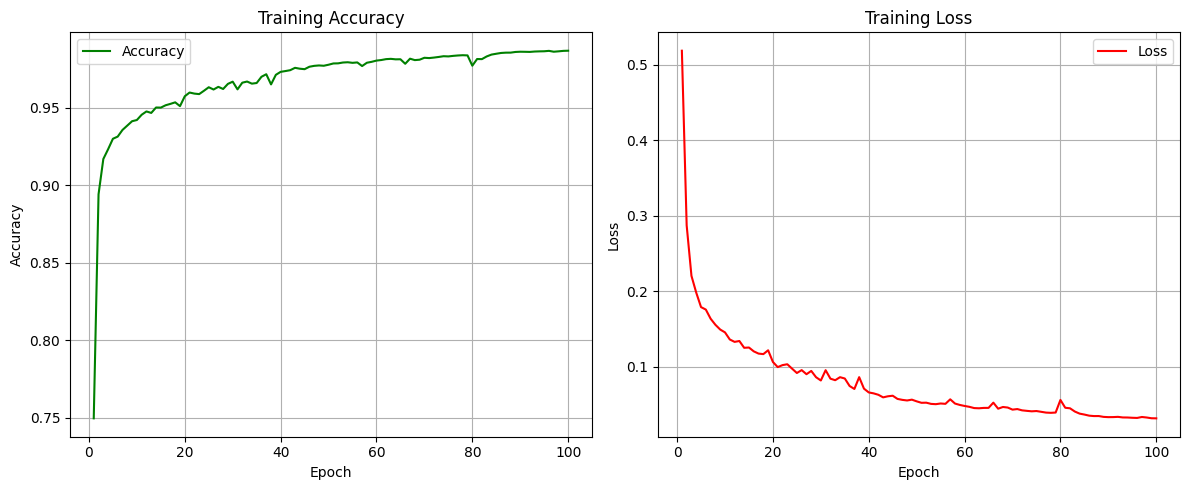

In [15]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('Median_2750.png', dpi=300)
plt.show()

In [16]:
def apply_morphology(mask, kernel_size=3, iterations=1):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask = (mask > 0.5).astype(np.uint8) 

    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=iterations)

    return opened.astype(np.float32)  


print("🔍 Đánh giá không hậu xử lý...")
results = segunet.evaluate(test_images_gray_gaus, test_masks, verbose=1)
loss, accuracy, jaccard = results
print(f"Không hậu xử lý - Dice Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, Jaccard: {jaccard*100:.2f}%")


print("\n🔧 Đánh giá sau Morphology...")
predictions1 = segunet.predict(test_images_gray_gaus)
refined_predictions1 = []

for i in tqdm(range(len(test_images_gray_gaus))):
    pred = predictions1[i].squeeze()
    morph_pred = apply_morphology(pred, kernel_size=7, iterations=2)

    refined_predictions1.append(morph_pred)

refined_predictions1 = np.expand_dims(np.array(refined_predictions1), axis=-1)


accuracy_after = np_accuracy(test_masks, refined_predictions1)
jaccard_after = np_jaccard_coefficient(test_masks, refined_predictions1)
loss_after = np_dice_loss(test_masks, refined_predictions1)
print(f"Sau Morphology - Dice Loss: {loss_after:.4f}, Accuracy: {accuracy_after*100:.2f}%, Jaccard: {jaccard_after*100:.2f}%")

🔍 Đánh giá không hậu xử lý...
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9532 - jaccard_coefficient: 0.7964 - loss: 0.1161

E0000 00:00:1765744905.159944     238 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765744905.399611     238 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 475ms/step - accuracy: 0.9528 - jaccard_coefficient: 0.7923 - loss: 0.1189
Không hậu xử lý - Dice Loss: 0.1534, Accuracy: 94.85%, Jaccard: 74.03%

🔧 Đánh giá sau Morphology...
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 317ms/step


100%|██████████| 825/825 [00:00<00:00, 1385.47it/s]


Sau Morphology - Dice Loss: 0.1342, Accuracy: 94.85%, Jaccard: 76.34%
